### Continuous state variables
<!-- ### 操作変数が連続な場合 -->

- When extending the model, more sophisticated methods are required
<!-- - モデルを拡張する場合には、より洗練された手法が必要になる -->

- The state variable is discretized whereas the continuous variable is continuous. When evaluating the value function between the grid points of the state variable, we use interpolation methods
<!-- - 状態変数のみ離散近似をして、操作変数については連続的な値を取り、価値関数を状態変数の間の値で評価するときは内挿法を用いる -->

- Algorithm
<!-- - アルゴリズム -->

1. Make the grid: Discretize evaluation points in the state space by the grid with $I=21$ points. Also, make an initial guess of the value function $V^{(0)}(k^{i})$ on the grid
<!-- 1. グリッド生成：状態空間の評価点を$I=21$個のグリッドに区切る。また、グリッド上における価値関数$V^{(0)}(k^{i})$の初期値を当て推量(initial guess)する -->

2. Convergence criteria: Set the parameter $\varepsilon=10^{-5}$ for the criteria of convergence
<!-- 2. 収束の基準：収束の基準になるパラメータ$\varepsilon=10^{-5}$を与える -->

3. Approximation and evaluation: Values of the value function not on $k^{i}$ must be approximated. Let $V(k;\mathbb{b})$ be the value of the value function on $k$ approximated by the parameter $\mathbb{b}$
<!-- 3. 近似・評価：$k^{i}$上にない価値関数の値については近似する必要がある。$V(k;\mathbb{b})$をパラメータ$\mathbb{b}$を使って近似した時の、$k$上での価値関数の値とする -->

4. Optimization: for each $k^{i}$, calculate
<!-- 4. 最適化：各$k^{i}$について、 -->

$$
  V^{(1)}(k^{i}) = \max_{k'} u([k^{i}]^{\alpha}+(1-\delta)k^{i}-k') + \beta V^{(0)}(k';\mathbb{b})
$$

To find $k'$ such that maximizes the value function, use optimization routines in each programming language
<!-- を計算する。価値関数を最大にする$k'$を探すためには、各言語の最適化関数を利用する -->

5. If $\|V^{(0)}(k^{i})-V^{(1)}(k^{i})\|<\varepsilon$ holds for all the $k^{i}$s, stop the algorithm. Otherwise, substitute $V^{(1)}(k^{i})$ into $V^{(0)}(k^{i})$ and iterate the steps 3-4
<!-- 5. 全ての$k^{i}$について$\|V^{(0)}(k^{i})-V^{(1)}(k^{i})\|<\varepsilon$であればストップ。そうでなければ、$V^{(1)}(k^{i})$を$V^{(0)}(k^{i})$に代入して、ステップ3-4を繰り返す -->

In [1]:
# Load packages 
using Dierckx
using Optim
using Plots
#pyplot()

In [3]:
# Load modules
include("GenerateGrid.jl")
include("MyEconFcn.jl")

Main.MyEconFcn

In [4]:
struct Params
    # parameters
    β::Float64 # Discount factor (\beta)
    γ::Float64 # Relative risk aversion (\gamma)
    α::Float64 # capital share (\alpha)
    δ::Float64 # capital depreciation \delta)

    # grid
    nk::Int64 # the number of grid points for capital
    kmax::Float64 # the maximum value of the grid for capital
    kmin::Float64 # the minimum value of the grid for capital
    kgrid::Vector{Float64} # the grid for capital

    # iterations
    maxit::Int64 # the maximum number of iterations
    tol::Float64 # the tolerance of errors
end

In [5]:
function calibration()
    β = 0.96
    γ = 1.0
    α = 0.4
    δ = 1.0 # 0.08

    nk = 21
    kmax = 0.5 # If \delta is 0.08, make it 10.0
    kmin = 0.05

    # Make equally distanced grid by own code
    kgrid = GenerateGrid.grid_uni(kmin, kmax, nk)
    # Or use it as before
    #kgrid = collect(LinRange(kmin, kmax, nk))

    maxit = 1000
    tol = 1e-5 # set the tolerance of errors

    return Params(β, γ, α, δ, nk, kmax, kmin, kgrid, maxit, tol)
end

calibration (generic function with 1 method)

In [9]:
params = calibration();

# Initial values for the value and policy functions
pfcn0 = zeros(params.nk) # use all the resources
vfcn0 = zeros(params.nk) 
# vfcn0 = MyEconFcn.crra.(params.kgrid.^params.α + (1-params.δ)*params.kgrid, params.γ) # the utility when consume everything

pfcn1 = zeros(params.nk)
vfcn1 = zeros(params.nk)

# Variables to save iteration errors
# Usually unnessesary as they are for the purpose of showing the iteration process
dif = zeros(2, params.maxit);

# calculate available assets beforehand
wealth = params.kgrid.^params.α + (1-params.δ)*params.kgrid;

In [7]:
function BellmanEq(params::Params, wealth::Float64, kprime::Float64, vnext::Spline1D)

    value = MyEconFcn.crra((wealth - kprime), params.γ) + params.β*vnext(kprime)
    value = -1*value
    return value 

end

BellmanEq (generic function with 1 method)

- Iteration errors become below $\varepsilon=1.0^{-5}$ after 200 iterations
<!-- - およそ200回で繰り返し計算誤差は$\varepsilon=1.0^{-5}$以下になる -->

- Iteration errors for the policy function get close to zero faster than the ones for the value function
<!-- - 価値関数の繰り返し計算誤差より政策関数の繰り返し計算誤差の方が早く0に近づいている -->

In [10]:
# Iterations for maxit times at the maximum
# Iteratively calculate the value function
for it = 1:params.maxit

    # Interpolate the next period's value function
    #vnext = Spline1D(params.kgrid, vfcn0, k=1, bc="extrapolate") # Linear interpolation
    vnext = Spline1D(params.kgrid, vfcn0, k=3, bc="extrapolate") # Spline interpolation

    for i = 1:params.nk
        BellmanEq!(kprime) = BellmanEq(params, wealth[i], kprime, vnext)
        res = optimize(BellmanEq!, 0.0, wealth[i], GoldenSection()) # optimization
        pfcn1[i] = res.minimizer
        vfcn1[i] = -res.minimum # reverse the sign as we looked for the minimum
    end

    # Check the convergence: Check errors in interations
    dif1 = maximum(abs.((vfcn1 - vfcn0)./vfcn0)) # Iteration errors for the value function
    dif2 = maximum(abs.((pfcn1 - pfcn0)./pfcn0)) # Iteration errors for the policy function (for plot)

    # Save errors in interations before the convergence
    # Usually unnessesary as they are for the purpose of showing the iteration process
    dif[1, it] = dif1
    dif[2, it] = dif2

    # Update the value and policy functions
    vfcn0 = deepcopy(vfcn1)
    pfcn0 = deepcopy(pfcn1)
    
    println([it,dif1])
    
    # Check if converged
    if dif1 < params.tol
        break
    end

    if it == params.maxit
        println("The model does not converge...")
    end
end

[1.0, Inf]
[2.0, 3.331788581461606]
[3.0, 0.8300217669784427]
[4.0, 0.45111274535826223]
[5.0, 0.3022973417150507]
[6.0, 0.22394792283832055]
[7.0, 0.17599606176755628]
[8.0, 0.14378268145367223]
[9.0, 0.12071726498939765]
[10.0, 0.10341857214220519]
[11.0, 0.08998104930164595]
[12.0, 0.07925231574191195]
[13.0, 0.07049586618348372]
[14.0, 0.06321953060885739]
[15.0, 0.05708212140097442]
[16.0, 0.05183974187263247]
[17.0, 0.047313445476266064]
[18.0, 0.043368975668464864]
[19.0, 0.03990363807989826]
[20.0, 0.03683754114262519]
[21.0, 0.03410759957703472]
[22.0, 0.031663335299924614]
[23.0, 0.029463877287249737]
[24.0, 0.02747577921785021]
[25.0, 0.025671406164625522]
[26.0, 0.02402772444587848]
[27.0, 0.02252538180156298]
[28.0, 0.02114799976073333]
[29.0, 0.019881623207535993]
[30.0, 0.01871428785944134]
[31.0, 0.017635677205258098]
[32.0, 0.016636848035386925]
[33.0, 0.015710009080268723]
[34.0, 0.014848341142877614]
[35.0, 0.014045849925822267]
[36.0, 0.013297244823570841]
[37.0, 0.

In [11]:
# compute the consumption function after obtaining the converged policy function
wealth = params.kgrid.^params.α + (1-params.δ)*params.kgrid
cfcn = wealth - pfcn0;

In [12]:
# compute the converged value function by using the policy function
util = zeros(params.nk)
valfn = zeros(params.nk)

for i = 1:params.nk
    cons = params.kgrid[i]^params.α + (1-params.δ)*params.kgrid[i] - pfcn0[i]
    util[i] = MyEconFcn.crra(cons, params.γ)
    valfn[i] = util[i] / (1-params.β)
end

In [13]:
# Analytical solution
AA = (1-params.β)^(-1) * (log(1-params.α*params.β) + ((params.α*params.β)/(1-params.α*params.β))*log(params.α*params.β))
BB = params.α / (1 - params.α*params.β)
v_true = AA .+ BB*log.(params.kgrid)
p_true = params.α*params.β*(params.kgrid.^params.α);

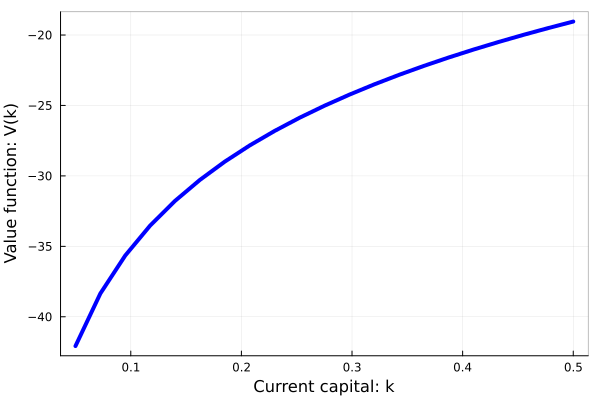

In [45]:
plt = plot(params.kgrid, valfn,
    color = :blue,
    legend = :none,
    xlabel = ("Current capital: k"),
    ylabel = ("Value function: V(k)"),
    linewidth = 4,
    legendfontsize = 12,
    framestyle = :semi
)

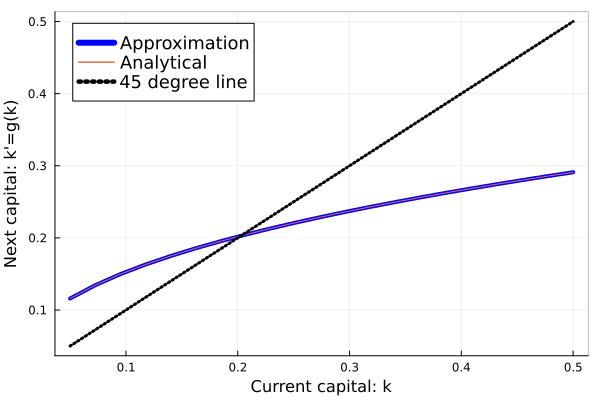

In [46]:
plt = plot(params.kgrid, pfcn0,
    color = :blue,
    legend = :topleft,
    label = ("Approximation"),
    xlabel = ("Current capital: k"),
    ylabel = ("Next capital: k'=g(k)"),
    linewidth = 4,
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.kgrid, p_true, linewidth = 1, label="Analytical")
plot!(params.kgrid, params.kgrid, linewidth = 3, color = "black", linestyle = :dot, label="45 degree line")

- Numerical errors in the Euler equation $u'(c)=\beta u'(f(k')-g(k'))f'(k')$ can be obtained by the equation below

$$
  \frac{\beta u'\big([g(k^{i})]^{\alpha}-g(g(k^{i}))\big)f'(g(k^{i}))}{u'\big([k^{i}]^{\alpha}-g(k^{i})\big)}-1
$$

where $k'=g(k)$

- Note that the errors are larger between the grid points

In [47]:
# original grid
kp_interp = Spline1D(params.kgrid, pfcn0, k=1, bc="extrapolate") # Linear interpolation of the policy function
LHS = MyEconFcn.mu_crra.(cfcn, params.γ) # marginal utility of today's consumption

kpp = kp_interp(pfcn0) # capital in the period after the next
cons_p = (pfcn0.^params.α) + (1-params.δ)*pfcn0 - kpp
rent = params.α*(pfcn0.^(params.α-1)) .- params.δ # r=f'(k)-\delta
RHS = params.β*(1 .+ rent) .* MyEconFcn.mu_crra.(cons_p, params.γ)
err_org = (RHS./LHS) .- 1

# finer grid
kp_interp = Spline1D(params.kgrid, pfcn0, k=1, bc="extrapolate") # Linear interpolation of the policy function
kgrid_err = GenerateGrid.grid_uni(params.kmin, params.kmax, (params.nk-1)*10+1) # finer grid
kp = kp_interp(kgrid_err)
cons = (kgrid_err .^ params.α) .+ (1 .- params.δ).*kgrid_err .- kp
LHS = MyEconFcn.mu_crra.(cons, params.γ) # marginal utility of today's consumption

kpp = kp_interp(kp) # capital in the period after the next
cons_p = (kp .^ params.α) + (1 .- params.δ).*kp .- kpp # kp_interp(pfcn0)
rent = params.α*(kp.^(params.α.-1)) .- params.δ # r=f'(k)-\delta
RHS = params.β*(1 .+ rent) .* MyEconFcn.mu_crra.(cons_p, params.γ)
err = (RHS./LHS) .- 1;

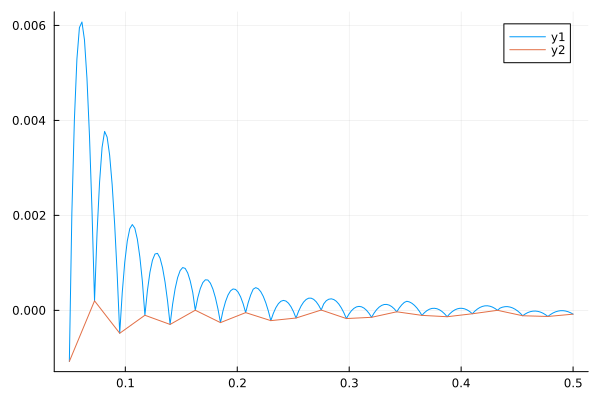

In [48]:
plot(kgrid_err,err)
plot!(params.kgrid,err_org)